## Notebook set up

In [49]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility
np.random.seed(42)

#Import CNN sklearn libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import Adamax
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier

#Import model selection
from sklearn.model_selection import train_test_split

#Import Grid Search
from sklearn.model_selection import GridSearchCV


## Preprocessing

In [5]:
#Read the X variable from the Data Architecture Notebook
X1 = np.load('cnn_dataset_rest.npy')
X2 = np.load('cnn_dataset_food.npy')
X3 = np.load('cnn_dataset_bars.npy')
X4 = np.load('cnn_dataset_shopping.npy')

X = np.concatenate((
    X1,
    X2,
    X3,
    X4
),
    axis=0)

In [6]:
#Check the shape
X.shape

(34108, 17, 16, 10)

In [7]:
#Import the target (y) variable from the Data Architecture Notebook
y1 = np.load('target_rest.npy')
y2 = np.load('target_food.npy')
y3 = np.load('target_bars.npy')
y4 = np.load('target_shopping.npy')

y = np.concatenate((
    y1,
    y2,
    y3,
    y4
),
    axis=0)

In [8]:
#Check the shape
y.shape

(34108,)

In [9]:
#Change datatype to float
X = X.astype('float32')

In [10]:
#Hot encode the y variable
y = np_utils.to_categorical(y,2).astype('float32')

In [11]:
#Import the numpy array that indicates that a business is a restaurant
r1 = np.load('rest_category.npy')
r2 = np.load('food_category.npy')
r3 = np.load('bars_category.npy')
r4 = np.load('shopping_category.npy')

r = np.concatenate((
    r1,
    r2,
    r3,
    r4
),
    axis=0)

In [12]:
#Mask X and y with r to show only restaurants in the model
mask = np.flatnonzero(r)

#Mask y to be the y var for the restaurants only
y = y[mask]

#Mask the X to be the y var for the restaurants only
X = X[mask]

#Check the shapes
X.shape, y.shape

((5924, 17, 16, 10), (5924, 2))

## Modelling


In [13]:
#Train test split the original df
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=592019,
                                                    stratify = y)

In [14]:
#Check shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4443, 17, 16, 10), (1481, 17, 16, 10), (4443, 2), (1481, 2))

In [15]:
#Display baseline accuracy for restaurants only the dataset
baseline = round(y_train[:,0].sum()/y_train.shape[0]*100,2)
print('Baseline accuracy is: ',baseline,'%')

Baseline accuracy is:  69.3 %


In [16]:
#Display baseline accuracy for restaurants only the dataset
baseline = round(y_test[:,0].sum()/y_test.shape[0]*100,2)
print('Baseline accuracy is: ',baseline,'%')

Baseline accuracy is:  69.28 %


In [17]:
X[0].shape

(17, 16, 10)

In [18]:
#Instantiate the model
#Create the network architechture

cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 64,
                     kernel_size = (5,5),
                     activation = 'relu',
                     input_shape = (X[0].shape),
                     padding = 'Same',
#                      kernel_regularizer = regularizers.l2(0.001)
                    ))

cnn_model.add(Conv2D(filters = 32,
                     kernel_size = (5,5),
                     activation = 'relu',
                     padding = 'Same',
                     kernel_regularizer = regularizers.l2(0.001)
                    ))

cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(filters = 64,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'Same',
#                      kernel_regularizer = regularizers.l2(0.001)
                    ))

cnn_model.add(Conv2D(filters = 64,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'Same',
#                      kernel_regularizer = regularizers.l2(0.001)
                    ))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.3))

#Flatten
cnn_model.add(Flatten())

cnn_model.add(Dense(256,
                    activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.001)
                   ))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(32,
                    activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.001)
                   ))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(2,
                activation = 'sigmoid'
))


# opt = optimizers.Nadam()
# opt = optimizers.Adamax(lr=0.001)
opt = optimizers.Adam(lr=.001)
#0.001, 0.005

#Pleateau Reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#Compile the model
cnn_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

eps = 50
batch = 64

#70 with 256

# eps = 30
# batch = 256, 512

# Fit model on training data.
history = cnn_model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        epochs=eps,
                        batch_size=batch,
                        callbacks = [learning_rate_reduction],
                        verbose=1)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 4443 samples, validate on 1481 samples
Epoch 1/50
4443/4443 [==============================] - 14s 3ms/step - loss: 0.8988 - acc: 0.6909 - val_loss: 0.7668 - val_acc: 0.6928
Epoch 2/50
4443/4443 [==============================] - 13s 3ms/step - loss: 0.6982 - acc: 0.6930 - val_loss: 0.6829 - val_acc: 0.6928
Epoch 3/50
4443/4443 [==============================] - 13s 3ms/step - loss: 0.6340 - acc: 0.6932 - val_loss: 0.6276 - val_acc: 0.6928
Epoch 4/50
4443/4443 [==============================] - 13s 3ms/step - loss: 0.5932 - acc: 0.7026 - val_loss: 0.6184 - val_acc: 0.7245
Epoch 5/50
4443/4443 [==============================] - 17s 4ms/step - loss: 0.5702 - acc: 0.7291 - val_loss: 0.6069 - val_acc: 0.7269
Epoch 6/50
4443/4443 [====================

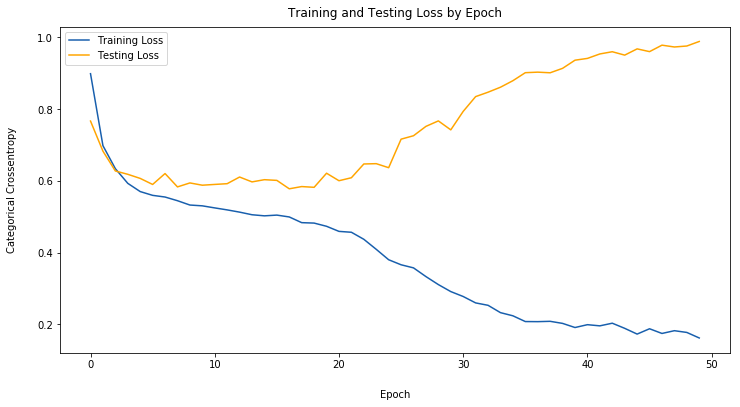

In [19]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12,6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 12, pad=10)
plt.xlabel('Epoch', fontsize = 10, labelpad =20)
plt.ylabel('Categorical Crossentropy', fontsize = 10, labelpad =20)
# plt.xticks(range(1,eps+1))

plt.legend(fontsize = 10);

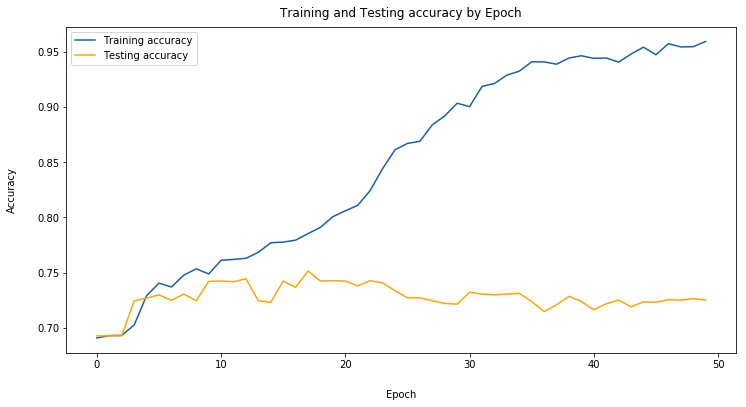

In [20]:
# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12,6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training accuracy', color='#185fad')
plt.plot(test_loss, label='Testing accuracy', color='orange')

# Set title
plt.title('Training and Testing accuracy by Epoch', fontsize = 12, pad = 10)
plt.xlabel('Epoch', fontsize = 10, labelpad =20)
plt.ylabel('Accuracy', fontsize = 10, labelpad =20)
# plt.xticks(range(1,eps+1), rotation = 90)

plt.legend(fontsize = 10);

# Grid search

In [69]:
#Set seeds for reproducibility
seed = 5142019
np.random.seed(seed)

#Create a model function
def create_model(filters_cl1 = 64,
                 kernel_size_cl1 = (5,5),
                 activ = 'relu',
                 input_shp = X_train[0].shape,
                 padding_cl1 = 'Same',
                 regular = 0.001,
                 neurons_dl1 = 256,
                 drop_rate = 0.3,
                 lr_opt = 0.002,
                 decay_opt = 0.0,
                 init_mode='uniform'):
    
    cnn_model = Sequential()
    cnn_model.add(Conv2D(filters = filters_cl1,
                         kernel_size = kernel_size_cl1,
                         kernel_initializer = init_mode,
                         activation = activ,
                         input_shape = input_shp,
                         padding = padding_cl1,
                         kernel_regularizer = regularizers.l2(regular)))
    cnn_model.add(Dropout(drop_rate))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(neurons_dl1,
                        activation = activ,
                        kernel_regularizer=regularizers.l2(regular)))
    cnn_model.add(Dropout(drop_rate))
    cnn_model.add(Dense(2,
                        activation = 'sigmoid'))
    
    #Set optimizer
    opt = Adamax(lr=lr_opt, decay=decay_opt)
    #Compile the model
    cnn_model.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])
    
    return cnn_model


model = KerasClassifier(build_fn = create_model,
                        epochs = 20,
                        batch_size = 256,
                        verbose = 1)

#GridSearch Parameters
batch_size = [512]
epochs = [50]
lr_opt = [0.007]
init_mode = ['glorot_uniform']
regular = [0.01]
drop_rate = [0.5]

param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  lr_opt = lr_opt,
                  init_mode = init_mode,
                  regular = regular,
                  drop_rate = drop_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
4443/4443 [==============================] - 12s 3ms/step - loss: 5.5063 - acc: 0.6465
Epoch 2/50
4443/4443 [==============================] - 8s 2ms/step - loss: 2.0998 - acc: 0.6430
Epoch 3/50
4443/4443 [==============================] - 7s 2ms/step - loss: 1.3099 - acc: 0.6762
Epoch 4/50
4443/4443 [==============================] - 7s 2ms/step - loss: 0.9900 - acc: 0.6829
Epoch 5/50
4443/4443 [==============================] - 7s 2ms/step - loss: 0.8862 - acc: 0.6903
Epoch 6/50
4443/4443 [==============================] - 7s 2ms/step - loss: 0.7815 - acc: 0.6884
Epoch 7/50
4443/4443 [==============================] - 7s 1ms/step - loss: 0.7147 - acc: 0.6918
Epoch 8/50
4443/4443 [==============================] - 6s 1ms/step - loss: 0.6728 - acc: 0.6929
Epoch 9/50
4443/4443 [==============================] - 7s 2ms/step - loss: 0.6530 - acc: 0.6914
Epoch 10/50
4443/4443 [==============================] - 6s 1ms/step - loss: 0.6362 - acc: 0.6955
Epoch 11/50
4443/4443 [=====

In [70]:
#Summary of results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means, params):
    print((mean, param))

Best: 0.747693 using {'batch_size': 512, 'drop_rate': 0.5, 'epochs': 50, 'init_mode': 'glorot_uniform', 'lr_opt': 0.007, 'regular': 0.01}
(0.7288993967027512, {'batch_size': 512, 'drop_rate': 0.1, 'epochs': 50, 'init_mode': 'glorot_uniform', 'lr_opt': 0.007, 'regular': 0.01})
(0.7460049522666279, {'batch_size': 512, 'drop_rate': 0.3, 'epochs': 50, 'init_mode': 'glorot_uniform', 'lr_opt': 0.007, 'regular': 0.01})
(0.7476930017812602, {'batch_size': 512, 'drop_rate': 0.5, 'epochs': 50, 'init_mode': 'glorot_uniform', 'lr_opt': 0.007, 'regular': 0.01})
(0.7384649979056686, {'batch_size': 512, 'drop_rate': 0.7, 'epochs': 50, 'init_mode': 'glorot_uniform', 'lr_opt': 0.007, 'regular': 0.01})
(0.7398154413058847, {'batch_size': 512, 'drop_rate': 0.8, 'epochs': 50, 'init_mode': 'glorot_uniform', 'lr_opt': 0.007, 'regular': 0.01})


### Model evaluation

In [ ]:
# Evaluate model on test data.
score = cnn_model.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = cnn_model.metrics_names

In [ ]:
# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')